In [70]:
import numpy as np
import scipy.stats
from astropy import units
import uvtools
from hera_pspec.conversions import Cosmo_Conversions
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams["font.size"] = "14"


# WINDOW function on FFT?

# Setup parameters
np.random.seed(5432)

SPECTRAL_WINDOW = 0

# ------------------------------
# Depend on spectral window
FRATE_FILTERS_FILE = "fr_ranges_"+str(SPECTRAL_WINDOW)+".pkl"

KBINS_FILE = "pre_release_maxbl_100m_minew_14m_kbins_SPW_"+str(SPECTRAL_WINDOW)+".pkl"
with open(KBINS_FILE, 'rb') as pickle_file:
    bins = pickle.load(pickle_file)


NFREQ = bins["kbins"].size*2         # k|| bins I think, bin edges I think
# ------------------------------


# These can be anything

LSTS_PER_NIGHT = 2160           # number them 0, 1, 2, etc
INTEGRATION_TIME = 10            # sec
COHERENT_INTEGRATION_LIMIT = 10  # sec
SECONDS_IN_DAY = 24*60*60

START_TIME = 2458902.4


# Based on above
FAKE_TIMES = np.array([ START_TIME+i*INTEGRATION_TIME/SECONDS_IN_DAY for i in range(LSTS_PER_NIGHT) ])

# Checks
assert COHERENT_INTEGRATION_LIMIT <= LSTS_PER_NIGHT*INTEGRATION_TIME, "Not enough times"
assert (LSTS_PER_NIGHT*INTEGRATION_TIME)%COHERENT_INTEGRATION_LIMIT == 0, "Coh integration time doesn't fit into night time"

In [71]:
# Trivial little classes/funcs to encapsulate things

class AntsManager:
    def __init__(self, ants_per_night, make_even_nights=False, all_nights_full=False):
        self.ants_per_night = ants_per_night     # Indexed by JD
        self.number_of_nights = len(ants_per_night.keys())
        
        self.ants_list = set()
        for night in ants_per_night:
            for ant in ants_per_night[night]:
                self.ants_list.add(ant)
                
        self.ants_list = list(self.ants_list)
        
        if make_even_nights and self.number_of_nights%2 == 1:
            all_jd = list(self.ants_per_night.keys())
            new_jd = all_jd[-1]+(all_jd[-1]-all_jd[-2])
            self.ants_per_night[new_jd] = self.ants_list
            self.number_of_nights = len(ants_per_night.keys())
            print(self.number_of_nights)
            
        if all_nights_full:
            for key in self.ants_per_night:
                self.ants_per_night[key] = self.ants_list
            
        
    def select(self, night_index):
        choose_night = list(self.ants_per_night.keys())[night_index]
        return self.ants_per_night[choose_night]
    
    def which_nights(self, ant):
        # Which nights does ant appear in
        nights = []
        for i in range(self.number_of_nights):
            if ant in self.select(i): nights.append(i)
        return nights
                
    
class BlManager:
    # Build a dictionary keyed by baseline i.e "(ant1, ant2)" .
    # All antennas are used here, so missing antennas (in a night) must be handled outside this.
    # Unpacks the baseline pairs so no baseline pairs in here.
    
    def __init__(self, bl_info):
        
        def parse_ants(a):
            ants = a.split("_")
            ants = ( int(ants[0]), int(ants[1]) )
            if ants[0] < ants[1]: return ants
            else:
                return ( ants[1], ants[0] )    # Flipped

            
        # Unpack the baselines from the pairs and make a dictionary keyed by baseline
        # self.available_bls contains all possible baselines
        self.available_bls = {}
        
        # Get the baseline lengths and build dictionary. Only done once.
        for i in range(len(bl_info["blp_groups"])):
            for j in range(len(bl_info["blp_groups"][i])):
                # extract bls from pair
                bl0 = bl_info["blp_groups"][i][j][0]
                bl1 = bl_info["blp_groups"][i][j][1]
                
                # add to dict with length
                self.available_bls[bl0] = bl_info["bl_lens"][i]
                self.available_bls[bl1] = bl_info["bl_lens"][i]
                
        
            
def fringe_rates(times):
    fr = uvtools.utils.fourier_freqs(times * units.day.to("s"))
    fr *= units.Hz.to("mHz")
    
    return fr    

def plot_histogram(a, xlabel, nbins=128, vals=False):

    def r(x):
        return np.round(x, 2)     # set_precision is not working for some reason at this time in the universe

    if a.dtype == np.complex128:
        real_hist, real_edges = np.histogram(a.real, bins=nbins)
        imag_hist, imag_edges = np.histogram(a.imag, bins=nbins)
        amp_hist, amp_edges = np.histogram(np.abs(a), bins=nbins)
        real_bins = (real_edges[:-1]+real_edges[1:])/2
        imag_bins = (imag_edges[:-1]+imag_edges[1:])/2
        amp_bins = (amp_edges[:-1]+amp_edges[1:])/2
        
        if vals:
            return real_hist, real_bins, imag_hist, imag_bins, amp_hist, amp_bins
        
        print("Real. Mean:", r(np.mean(a.real)), "Std", np.std(a.real), "Skew", r(scipy.stats.skew(a.real)), 
              "Kurtosis", r(scipy.stats.kurtosis(a.real)))
        print("Imag. Mean:", r(np.mean(a.imag)), "Std", np.std(a.imag), "Skew", r(scipy.stats.skew(a.imag)), 
              "Kurtosis", r(scipy.stats.kurtosis(a.imag)))
        print("Amp. Mean:", r(np.mean(np.abs(a))), "Std", np.std(np.abs(a)), "Skew", r(scipy.stats.skew(np.abs(a))), 
              "Kurtosis", r(scipy.stats.kurtosis(a.imag)))
        
        plt.title("Histogram")
        plt.ylabel("Count")
        plt.xlabel(xlabel)
        plt.plot(real_bins, real_hist, label="Real")
        plt.plot(imag_bins, imag_hist, label="Imag")
        plt.plot(amp_bins, amp_hist, label="Amp")
        plt.legend()
    else:
        hist, edges = np.histogram(a.real, bins=nbins)
        bins = (edges[:-1]+edges[1:])/2
        
        if vals:
            return hist, bins
        
        print("Mean:", np.mean(a.real), "Skew:", scipy.stats.skew(a.real), "Kurtosis:", scipy.stats.kurtosis(a.real))
 
        plt.title("Histogram")
        plt.ylabel("Count")
        plt.xlabel("Covariance")
        plt.plot(bins, hist)

def plot_corrcoef(a, title):
    matrix = np.corrcoef(a)
    plt.matshow(matrix)
    plt.colorbar()
    plt.title(title)
    
def is_gauss(a):
    """
    Problem is that the baseline length is not much
    """
    re, im = scipy.stats.kstest(a.real, "norm").pvalue, scipy.stats.kstest(a.imag, "norm").pvalue

    val = max(re, im)
    
    return val
    
    for comp in [ np.real, np.imag ]:
        for stat in [ (np.mean, 0.3), (scipy.stats.skew, 0.3), (scipy.stats.kurtosis, 0.3) ]:
            print(np.abs(stat[0](comp(a))))
            if np.abs(stat[0](comp(a))) > stat[1]:
                return False
            
    return True


print(is_gauss(np.random.normal(size=NFREQ)+np.random.normal(size=NFREQ)*1j))
    
    
index_of = lambda a, val: np.where(a==val)[0][0]

0.5056984274035787


In [72]:
## Load data, do sanity checks and report ------------------------------------
def report_on_data():
    
    with open("keep_ants.pickle", 'rb') as pickle_file:
        ants_per_night = pickle.load(pickle_file)["cut_bad_auto_spectra"]

    print("Report on data ---------------\n")

    ants_list = set()
    for night in ants_per_night:
        for ant in ants_per_night[night]:
            ants_list.add(ant)
    print("Num nights:", len(ants_per_night.keys()), "Num ants from nights_per_ant:", len(ants_list))

    with open("pspec_redundant_groups.pkl", 'rb') as pickle_file:
        bls = pickle.load(pickle_file)
    assert len(bls["blp_groups"]) == len(bls["bl_lens"])

    if np.min(np.diff(bls["bl_lens"])) > -1:      
        print("Redundant groups are approximately in length order")

    print("Got", len(bls["blp_groups"]), "redundant groups")

    bl_manager = BlManager(bls)

    lengths = [ len(gr) for gr in bls["blp_groups"] ]
    print("Min group length", min(lengths), "Max group length", max(lengths))
    #for gr in bls["blp_groups"]:
    #    print(len(gr))


    # Find all the ants in the groups
    ants_list_bls = set()
    for gr in bls["blp_groups"]:
        for pairs in gr:
            for bl in pairs:
                for ant in bl:
                    ants_list_bls.add(ant)
    print("Num ants from pspec_redundant_groups:", len(ants_list_bls))

    empty_or_not = lambda s : None if len(s) == 0 else s
    print("These antennas from nights_per_ant do not appear in pspec_redundant_groups:", 
          empty_or_not(ants_list.difference(ants_list_bls)))

    print("Examples of baseline pairs:", bls["blp_groups"][0][0], bls["blp_groups"][100][0] )

    print()
    for spw in range(9): 
        f = "pre_release_maxbl_100m_minew_14m_kbins_SPW_"+str(spw)+".pkl"
        print(f)
        with open(f, 'rb') as pickle_file:
            bins = pickle.load(pickle_file)

        assert bins["kbins"].size == bins["kbin_widths"].size
        print("\tnbins", bins["kbins"].size, "bin_range", bins["kbins"][0], "-", bins["kbins"][-1], "freq range", bins["freq_range"], "\n\t\tkwidths", np.unique(bins["kbin_widths"]))

    ants_manager = AntsManager(ants_per_night)

    # -- fringe rates -------------------------------------------

    for i in range(9):
        f = "fr_ranges_"+str(i)+".pkl"
        with open(f, 'rb') as pickle_file:
            rates = pickle.load(pickle_file)
        print(f)
        print("\tFringe centres", min(rates[0].values()), "to", max(rates[0].values()), "Baselines", 
              len(rates[0].values()))
        print("\tFringe widths", min(rates[1].values()), "to", max(rates[1].values()), "Baselines", 
              len(rates[1].values()))


        # Could check if all the baselines exist elsewhere

    frates = fringe_rates(FAKE_TIMES)

    print()
    print("Fringe rates available in the sim", frates[0], "to", frates[-1])
    print(np.unique(np.diff(frates)))
    
report_on_data()

Report on data ---------------

Num nights: 23 Num ants from nights_per_ant: 91
Redundant groups are approximately in length order
Got 652 redundant groups
Min group length 1 Max group length 1035
Num ants from pspec_redundant_groups: 91
These antennas from nights_per_ant do not appear in pspec_redundant_groups: None
Examples of baseline pairs: ((24, 25), (44, 45)) ((5, 25), (17, 39))

pre_release_maxbl_100m_minew_14m_kbins_SPW_0.pkl
	nbins 24 bin_range 0.0 - 1.2880070141896636 freq range (48141479.4921875, 59738159.1796875) 
		kwidths [0.02800015]
pre_release_maxbl_100m_minew_14m_kbins_SPW_1.pkl
	nbins 22 bin_range 0.0 - 1.5021434826050324 freq range (65231323.2421875, 75607299.8046875) 
		kwidths [0.03576532]
pre_release_maxbl_100m_minew_14m_kbins_SPW_2.pkl
	nbins 22 bin_range 0.0 - 1.609246651343047 freq range (75607299.8046875, 85983276.3671875) 
		kwidths [0.0383154]
pre_release_maxbl_100m_minew_14m_kbins_SPW_3.pkl
	nbins 25 bin_range 0.0 - 1.8733514905514201 freq range (109786987

In [73]:
def average(bls, weight):
    summed = np.zeros(NFREQ, complex)
    
    if len(bls) == 0: return None
    
    if weight:
        variance = [ np.var(bl) for bl in bls ]
        
    else:
        variance = [ 1 for bl in bls ]
        
        
    sum_var = 0.0
    for i in range(len(bls)):
        summed += bls[i]/variance[i]
        sum_var += 1/variance[i]
    return summed/sum_var
        
        
def complex_array(length, zeroed=False):
    if zeroed:
        return np.full(length, 0, dtype=np.complex)
    else:
        return np.random.normal(size=length)+np.random.normal(size=length)*1j
    
def fringe_rate_filter(bl_by_time, bls_to_use):
    """
    Expecting a list of observations in time. Each observation is a dictionary of different baselines.
    A baseline is a 1-D array of length nfreqs.
    """
    
    
    f = FRATE_FILTERS_FILE
    with open(f, 'rb') as pickle_file:
        rates = pickle.load(pickle_file)

    
    if len(bl_by_time) == len(FAKE_TIMES):
        frates = fringe_rates(FAKE_TIMES)
    else:
        print("Calculating fringe rates for integrated times")
        assert FAKE_TIMES.size%len(bl_by_time) == 0, "Can't reduce times for FRF"
        scrunch_factor = len(FAKE_TIMES)//len(bl_by_time)
        frf_fake_times = np.mean(np.resize(FAKE_TIMES, (FAKE_TIMES.size//scrunch_factor, scrunch_factor)), axis=1)
        frates = fringe_rates(frf_fake_times)
        
    # Get nfreqs
    key0 = list(bl_by_time[0].keys())[0]
    nfreq = bl_by_time[0][key0].size
           
    start = time.time()
    for bl in bls_to_use:
        
        # See if all times are None or all not None
        all_None = len([ bls[bl] for bls in bl_by_time if bls[bl] is None ]) == len(bl_by_time)
        all_not_None = len([ bls[bl] for bls in bl_by_time if bls[bl] is not None ]) == len(bl_by_time)
        
        assert (all_None and not all_not_None) or (not all_None and all_not_None), "BL "+str(bl)+"has some None baselines"

        if all_not_None:
            # Form an array that is the baseline by time. What about if baseline is missing in one time.
            data = np.zeros((len(bl_by_time), nfreq), complex)


            for i in range(len(bl_by_time)):
                data[i] = bl_by_time[i][bl] 

            fft = np.fft.fftshift(np.fft.fft(data, axis=0), axes=0)
            # now for a frequency index F, fft[:, F] is the fft by time with the -ve frequencies, then DC
            # then the +ve frequencies. If there are 8 times then the modes are  -4 -3 -2 -1 0 1 2 3

            # Find the tophat filter vals for this baseline
            key = (bl[0], bl[1], "ee")
            centre = rates[0][key]
            width = rates[1][key]
            #print(centre, width)

            # left and right edges of the tophat. These are fringe rates.
            left = centre-width/2
            right = centre+width/2

            # Find the index of these fringe rates. The bottom then the top
            indexes = np.arange(frates.size, dtype=int)
            left_index = np.where(frates<left)[0][-1]-1
            right_index = np.where(frates>right)[0][0]+1
            assert left_index < right_index, "fringe rates don't have enough resolution"

            #print(left_index, right_index)
            #print(frates[left_index], frates[right_index]); 
            # Now zero everything outside of the tophat
            fft[:left_index, :] = 0j
            fft[right_index:, :] = 0j

            # Now put things back. Invert the fft.
            data = np.fft.ifft(np.fft.ifftshift(fft, axes=0), axis=0)

            for i in range(len(bl_by_time)):
                bl_by_time[i][bl] = data[i]
            
    #print("FRF time", time.time()-start)   

    


def run_pipeline(do_frf=False, do_fft=False, time_interleaving=False, do_weight=False, do_report=False):
    
    usage_found_0 = False
    bl_crossed_itself = False
    
    if do_frf and not do_fft:
        raise RuntimeError("Must do FFT if doing FRF")
    
    with open("pspec_redundant_groups.pkl", 'rb') as pickle_file:
        bls = pickle.load(pickle_file)
    bl_manager = BlManager(bls)
    
    with open("keep_ants.pickle", 'rb') as pickle_file:
        ants_per_night = pickle.load(pickle_file)["cut_bad_auto_spectra"]
    ants_manager = AntsManager(ants_per_night)
    
    fft = lambda a: np.fft.fftshift(np.fft.fft(a))/a.size      # Normalize
    
    # LST binning. Assume the same LSTs are used every night. Start with the assumption that all 
    # available baselines can be used, and keep track of unused baselines with a weight value.
    
    lst_binned = [ dict.fromkeys(bl_manager.available_bls, []) for j in range(LSTS_PER_NIGHT) ]
    # Want to keep a total of how many baselines went into a result. This will keep updating/changing.
    usage_at_lst_bin = [ dict.fromkeys(bl_manager.available_bls, 0) for j in range(LSTS_PER_NIGHT) ]
    
    for j in range(LSTS_PER_NIGHT):
        for i in range(ants_manager.number_of_nights):
            
            ants_this_night = ants_manager.select(i)
                        
            # Have to take care of missing baselines when we add
            for bl in bl_manager.available_bls:
                if bl[0] in ants_this_night and bl[1] in ants_this_night:
                    lst_binned[j][bl] = lst_binned[j][bl]+[complex_array(NFREQ)]  # append doesn't work
                    usage_at_lst_bin[j][bl] += 1
                    

    
    # Now average
    for j in range(LSTS_PER_NIGHT):
        for bl in bl_manager.available_bls:
                # replace arrays with average
            usage_at_lst_bin[j][bl] = len(lst_binned[j][bl])
            lst_binned[j][bl] = average(lst_binned[j][bl], do_weight)
            if lst_binned[j][bl] is None: assert usage_at_lst_bin[j][bl] == 0
            if lst_binned[j][bl] is not None: 
                assert usage_at_lst_bin[j][bl] > 0, "FRF check failed "+str(j)+" "+str(bl)         
                assert np.max(np.abs(lst_binned[j][bl])) > 0, "FRF check failed "+str(j)+" "+str(bl)    
            
    print("LST binned")
       
              
    # Report
    if do_report:
        where_min = where_max = -1
        used_max = 0
        used_min = 2**32

        zero_weighted = []
        for i in range(len(usage_at_lst_bin)):
            for bl in usage_at_lst_bin[i]:
                if usage_at_lst_bin[i][bl] > used_max:
                    where_max = bl
                    used_max = usage_at_lst_bin[i][bl]
                if usage_at_lst_bin[i][bl] < used_min:
                    where_min = bl
                    used_min = usage_at_lst_bin[i][bl]
                if usage_at_lst_bin[i][bl] == 0:
                    zero_weighted.append(bl)


        if len(zero_weighted) == 0: 
            print("All baselines used for all LSTs")
        else: 
            print("Some baselines not used:", zero_weighted)
        print("most used bl", where_max, used_max, "least used bl", where_min, used_min)
    
    # Coherent. Accumulate the averages in particular observations and then discard the other ones.
    # Now keep track of how many beaselines went into each result (usage).
        
    lsts_per_coherent = COHERENT_INTEGRATION_LIMIT//INTEGRATION_TIME
    num_coherent_bins = LSTS_PER_NIGHT//lsts_per_coherent
    
    coherent_binned = [ dict.fromkeys(bl_manager.available_bls, []) for j in range(num_coherent_bins) ]

    usage_at_coherent_bin = [ dict.fromkeys(bl_manager.available_bls, 0) for j in range(num_coherent_bins) ]    
    
    for coherent_lst in range(num_coherent_bins):

        for j in range(lsts_per_coherent):
            for bl in bl_manager.available_bls:
                
                # Correct behaviour if a bl is not used (0 weight and 0 value)
                lst = coherent_lst*lsts_per_coherent+j
                if lst_binned[lst][bl] is not None:
                    coherent_binned[coherent_lst][bl] = coherent_binned[coherent_lst][bl]+[lst_binned[lst][bl]]
                    usage_at_coherent_bin[coherent_lst][bl] += usage_at_lst_bin[lst][bl] 
                else: 
                    
                    assert usage_at_lst_bin[lst][bl] == 0, "usage not right"

    # Now average
    for coherent_lst in range(num_coherent_bins):
        for bl in bl_manager.available_bls:
            # Replace bls with its average
            coherent_binned[coherent_lst][bl] = average(coherent_binned[coherent_lst][bl], do_weight)
            if coherent_binned[coherent_lst][bl] is None: assert usage_at_coherent_bin[coherent_lst][bl] == 0
            if coherent_binned[coherent_lst][bl] is not None: 
                assert usage_at_coherent_bin[coherent_lst][bl] > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)    
                assert np.max(np.abs(coherent_binned[coherent_lst][bl])) > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)    

    print("Coherent binned")

    if do_frf: 
        for coherent_lst in range(num_coherent_bins):
            for bl in bl_manager.available_bls:
                if coherent_binned[coherent_lst][bl] is None: 
                    assert usage_at_coherent_bin[coherent_lst][bl] == 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)    
                if coherent_binned[coherent_lst][bl] is not None: 
                    assert usage_at_coherent_bin[coherent_lst][bl] > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)      
                if coherent_binned[coherent_lst][bl] is not None:
                    assert np.max(np.abs(coherent_binned[coherent_lst][bl])) > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)  

        fringe_rate_filter(coherent_binned, list(bl_manager.available_bls.keys()))  # From this point can't assume Gaussianity
        print("FR Filtered")
        for coherent_lst in range(num_coherent_bins):
            for bl in bl_manager.available_bls:
                if coherent_binned[coherent_lst][bl] is None: 
                    assert usage_at_coherent_bin[coherent_lst][bl] == 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)    
                if coherent_binned[coherent_lst][bl] is not None: 
                    assert usage_at_coherent_bin[coherent_lst][bl] > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)      
                if coherent_binned[coherent_lst][bl] is not None:
                    assert np.max(np.abs(coherent_binned[coherent_lst][bl])) > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)  

    
    # Now come to pair multiplication
    # Each LST has baselines in redundant groups. If no time interleaving then all possible pairs in a
    # redundant group are cross multiplied, leaving a set of cross-powers in the redundant group.
    # If time interleaving, then the seond baseline in the pair is selected from the next time step.
    
    if time_interleaving:
        assert len(coherent_binned) %2 == 0, "Don't have even number of times for time interleaving"
        
        crossed = [ [ [] for i in range(len(bls["blp_groups"])) ] for j in range(len(coherent_binned)//2) ]

        usage_at_crossed = [ [ 0 for i in range(len(bls["blp_groups"])) ] for j in range(len(coherent_binned)//2) ]  

        for coherent_lst in range(0, len(coherent_binned), 2):
            for group_id, group in enumerate(bls["blp_groups"]):      # bls["blp_groups"] has the pairs

                # Go through all the pairs, generate a cross power value, and store them all for later averaging

                for pair in group:

                    # Get baselines 
                    bl0 = pair[0]
                    bl1 = pair[1]
                    
                    #if bl0 == bl1:
                    #    print("Attempt cross", bl0, bl1, "in t", coherent_lst, "group", group_id)

                    # What to do with a redundant group that only has 1 pair, and that is a baseline crossed with
                    # itself. In time interleaving we allow this.

                    if coherent_binned[coherent_lst][bl0] is not None and coherent_binned[coherent_lst+1][bl1] is not None:
                        assert usage_at_coherent_bin[coherent_lst][bl0] > 0 and usage_at_coherent_bin[coherent_lst+1][bl1] > 0, \
                                    "usage not right"
                        
                        if do_fft:
                       
                            cross_power = fft(coherent_binned[coherent_lst][bl0])* \
                                                np.conj(fft(coherent_binned[coherent_lst+1][bl1]))
                        else:                        
                            cross_power = coherent_binned[coherent_lst][bl0]*np.conj(coherent_binned[coherent_lst+1][bl1])

                        crossed[coherent_lst//2][group_id] = crossed[coherent_lst//2][group_id]+[cross_power]
                        usage_at_crossed[coherent_lst//2][group_id] += \
                                usage_at_coherent_bin[coherent_lst][bl0]+usage_at_coherent_bin[coherent_lst+1][bl1]
                        
                    elif coherent_binned[coherent_lst][bl0] is None:
                        assert usage_at_coherent_bin[coherent_lst][bl0] == 0, "usage not right"
                        
                
                    elif coherent_binned[coherent_lst+1][bl1] is None:
                        assert usage_at_coherent_bin[coherent_lst+1][bl1] == 0, "usage not right"
        
 
    else:
    
        crossed = [ [ [] for i in range(len(bls["blp_groups"])) ] for j in range(len(coherent_binned)) ]

        usage_at_crossed = [ [ 0 for i in range(len(bls["blp_groups"])) ] for j in range(len(coherent_binned)) ]  

        for coherent_lst in range(len(coherent_binned)):
            for group_id, group in enumerate(bls["blp_groups"]):      # bls["blp_groups"] has the pairs

                # Go through all the pairs, generate a cross power value, and store them all for later averaging

                for pair in group:

                    # Get baselines 
                    bl0 = pair[0]
                    bl1 = pair[1]
                    
                    #if bl0 == bl1:
                    #    print("Attempt cross", bl0, bl1, "in t", coherent_lst, "group", group_id)

                    # What to do with a redundant group that only has 1 pair, and that is a baseline crossed with
                    # itself. If we don't allow it then that group has no result.
                    # There ARE baseline pairs like that.Should get rid of them earlier up.

                    if bl0 != bl1 and coherent_binned[coherent_lst][bl0] is not None and coherent_binned[coherent_lst][bl1] is not None:
                        assert usage_at_coherent_bin[coherent_lst][bl0] > 0 and usage_at_coherent_bin[coherent_lst][bl1] > 0, \
                                "usage not right"
                        
                        if do_fft:
                            fft1 = fft(coherent_binned[coherent_lst][bl0])
                            fft2 = fft(coherent_binned[coherent_lst][bl1])
                            cross_power = fft1* np.conj(fft2)
                        else:                        
                            cross_power = coherent_binned[coherent_lst][bl0]*np.conj(coherent_binned[coherent_lst][bl1])


                        crossed[coherent_lst][group_id] = crossed[coherent_lst][group_id]+[cross_power]
                        usage_at_crossed[coherent_lst][group_id] += \
                                usage_at_coherent_bin[coherent_lst][bl0]+usage_at_coherent_bin[coherent_lst][bl1]
                        
                    elif coherent_binned[coherent_lst][bl0] is None:
                        assert usage_at_coherent_bin[coherent_lst][bl0] == 0, "usage not right"
                        
                    elif coherent_binned[coherent_lst][bl1] is None:
                        assert usage_at_coherent_bin[coherent_lst][bl1] == 0, "usage not right"
                        
                        
    print("Cross-powered")
    # Now average cross-powers

    for coherent_lst in range(len(crossed)):
        for group_id, group in enumerate(bls["blp_groups"]): 
            # Replace bls with their average
            crossed[coherent_lst][group_id] = average(crossed[coherent_lst][group_id], do_weight)
            if crossed[coherent_lst][group_id] is None: 
                assert usage_at_crossed[coherent_lst][group_id] == 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)  
            if crossed[coherent_lst][group_id] is not None:
                assert np.max(np.abs(crossed[coherent_lst][group_id])) > 0, "FRF check failed "+str(coherent_lst)+" "+str(bl)  

            
    # Now we have a bunch of times (LSTS) that have N baselines in them where N is the number of redundant
    # groups. Now we can integrate all the times together.
    
    fully_integrated = [ [] for i in range(len(bls["blp_groups"])) ]
    usage = [ 0 for i in range(len(bls["blp_groups"])) ]  
    empty_groups = []
    for group_id in range(len(bls["blp_groups"])):
        for coherent_lst in range(len(crossed)):
            if crossed[coherent_lst][group_id] is not None:
                assert usage_at_crossed[coherent_lst][group_id] > 0, "usage not right"
                
                fully_integrated[group_id] = fully_integrated[group_id]+[crossed[coherent_lst][group_id]]
                usage[group_id] += usage_at_crossed[coherent_lst][group_id]
                
            else:

                assert usage_at_crossed[coherent_lst][group_id] == 0, "usage not right"
                usage_found_0 = True
                
                empty_groups.append(group_id)
    
    empty_groups = np.unique(empty_groups)

    # Now average 

    for group_id in range(len(bls["blp_groups"])):
        fully_integrated[group_id] = average(fully_integrated[group_id], do_weight)
        if fully_integrated[group_id] is None:
            assert usage[group_id] == 0, "check failed "+str(group_id)+" "+str(bl)  
        else:
            assert np.max(np.abs(fully_integrated[group_id])) > 0, "check failed "+str(group_id)+" "+str(bl)
            assert usage[group_id] > 0, "check failed "+str(group_id)+" "+str(bl)  
            
    print("Time averaged")
    
    print("usage_found_0?", usage_found_0)
    print("bl_crossed_itself?", bl_crossed_itself)

            
    return fully_integrated, empty_groups, usage

def binned(x, y, nbins):
    # Can bin complex numbers but must return them as real
    def abs_mean(a):
        if len(a) == 0: return 0
        else: return np.abs(np.mean(a))

    bin_means, bin_edges, _ = scipy.stats.binned_statistic(x, y, statistic=abs_mean, bins=nbins)
    return bin_means, bin_edges

def make_wedge(bls, width):
    

    cosmo = Cosmo_Conversions()
    
    with open(KBINS_FILE, 'rb') as pickle_file:
        bins = pickle.load(pickle_file)
                
    with open("pspec_redundant_groups.pkl", 'rb') as pickle_file:
        bl_info = pickle.load(pickle_file)
        
    usable_bls = np.array([ bl for bl in bls if bl is not None ])

    print("Before binning, Range:", np.min(np.abs(usable_bls)), "-", np.max(np.abs(usable_bls)))


    freq_range = bins["freq_range"]
    average_freq = (freq_range[1]+freq_range[0])/2
    z = cosmo.f2z(average_freq)
    scale_factor = cosmo.bl_to_kperp(z)
    
    k_perps = [ scale_factor*length for i, length in enumerate(bl_info["bl_lens"]) if bls[i] is not None ]
    
    # Do binning cross k_perp axis
    
    sequences = [ usable_bls[:, i] for i in range(usable_bls.shape[1]) ]
    vals, edges = binned(k_perps, sequences, 52)
    
    # Put the binned sequences back in place of the unbinned
    ps = np.zeros((len(vals[0]), len(vals)))
    for i in range(len(vals)):
        ps[:, i] = vals[i]

    # Clip zeros at the left and right
    ps_by_bl = np.average(ps, axis=1)
    left = np.argmax(ps_by_bl>0)                # where first non-0 value
    right = np.argmax(ps_by_bl[::-1]>0)      # where last non-0 value, from the end

    if right == 0: 
        edges = edges[left:]
        ps = ps[left:]
    else:
        edges = edges[left:-right]
        ps = ps[left:-right]
        
        
    print("After binning, Range:", np.min(np.abs(ps)), "-", np.max(np.abs(ps)))
        
    # About the extents. If the pixels are "bins" and the first pixel has bin edges 0-1 and the last 
    # pixel has bin edges 9-10 then the extent is 0, 10. 

    
    plt.imshow(np.abs(ps.T), aspect="auto", extent=[edges[0], edges[-1], -bins["kbins"][-1],
                                                    bins["kbins"][-1], ], norm=LogNorm())
    plt.colorbar()
    plt.ylabel("$k_{\parallel}$ [h Mpc$^{-1}$]", fontsize=15)
    plt.xlabel("$k_{\perp}$ [h Mpc$^{-1}$]", fontsize=15)
    plt.title("$Power$ [mk$^2$ h$^{-3}$ Mpc$^{-3}$]", fontsize=15)

    
def spherical_average(bls, width):
    cosmo = Cosmo_Conversions()
    
    with open(KBINS_FILE, 'rb') as pickle_file:
        bins = pickle.load(pickle_file)
                
    with open("pspec_redundant_groups.pkl", 'rb') as pickle_file:
        bl_info = pickle.load(pickle_file)

    freq_range = bins["freq_range"]
    average_freq = (freq_range[1]+freq_range[0])/2
    z = cosmo.f2z(average_freq)
    scale_factor = cosmo.bl_to_kperp(z)
    
    usable_bls = [ bl for bl in bls if bl is not None ]
    
    print("Before folding, Range:", np.min(np.abs(usable_bls)), "-", np.max(np.abs(usable_bls)))
    
    k_perps = [ scale_factor*length for i, length in enumerate(bl_info["bl_lens"]) if bls[i] is not None ]   
       
    ks = []
    k_powers = []


    for i in range(len(usable_bls)):
        # Need to fold the +ve and negative frequencies, not Nyquist and DC. See Appendix. 
            
        # If modes are -4 -3 -2 - 0 1 2 3 (for example), start with -4 -3 -2 -1 0 flipped
        # to be 0 -1 -2 -3 -4
        folded = np.copy(usable_bls[i][:NFREQ//2+1][::-1])

        # Now add the mode values for modes 1 2 3
        folded[1:-1] += usable_bls[i][NFREQ//2+1:]

        # Now can scan the folded delay spectrum and use the values
        for j in range(NFREQ//2):
            k = np.sqrt(k_perps[i]**2+bins["kbins"][j]**2)
            ks.append(k)
            k_powers.append(k**3*folded[j]/(2*np.pi**2))
            
    print("After dimensionless, Range:", np.abs(np.min(k_powers)), "-", np.abs(np.max (k_powers)))

    ks = np.array(ks)
    k_powers = np.array(k_powers)
                
    vals, bin_edges = binned(ks, k_powers, 52)
    bin_avs = (bin_edges[1:]+bin_edges[:-1])/2
            
    plt.scatter(bin_avs[vals>0], vals[vals>0])
    plt.xlabel("$k$ [h Mpc$^{-1}$]", fontsize=15)
    plt.ylabel("$\Delta^2$ [mk$^2$]", fontsize=15)



# Run the pipeline

In [74]:
integrated, empties, usage = run_pipeline(do_weight=True, do_fft=True, do_frf=True,  time_interleaving=True)
print("Empty groups", empties, "("+str(len(empties))+")")
print("Finally, got", len(integrated), "cross-powers")

LST binned
Coherent binned
FR Filtered
Cross-powered
Time averaged
usage_found_0? False
bl_crossed_itself? False
Empty groups [] (0)
Finally, got 652 cross-powers


Text(0.5, 0, 'Group')

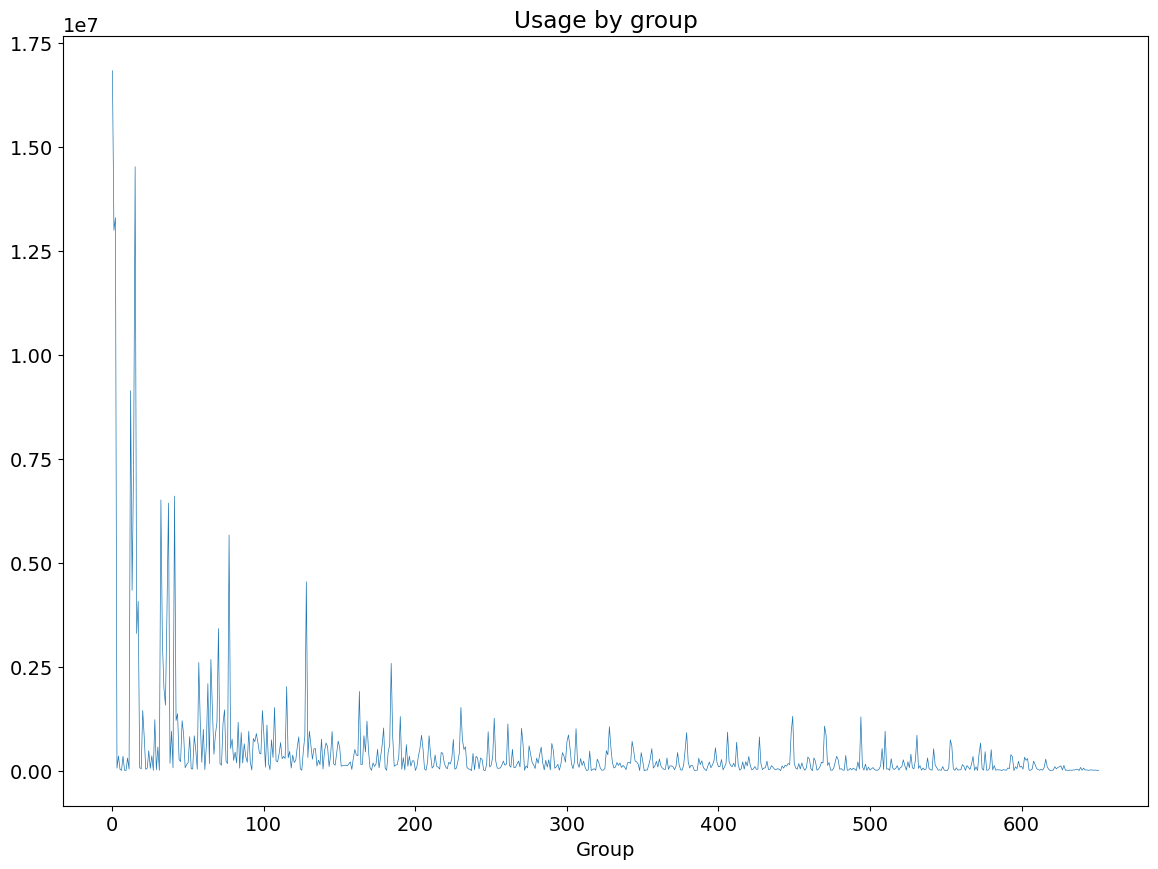

In [75]:
plt.plot(usage, lw=0.5)
plt.title("Usage by group")
plt.xlabel("Group")

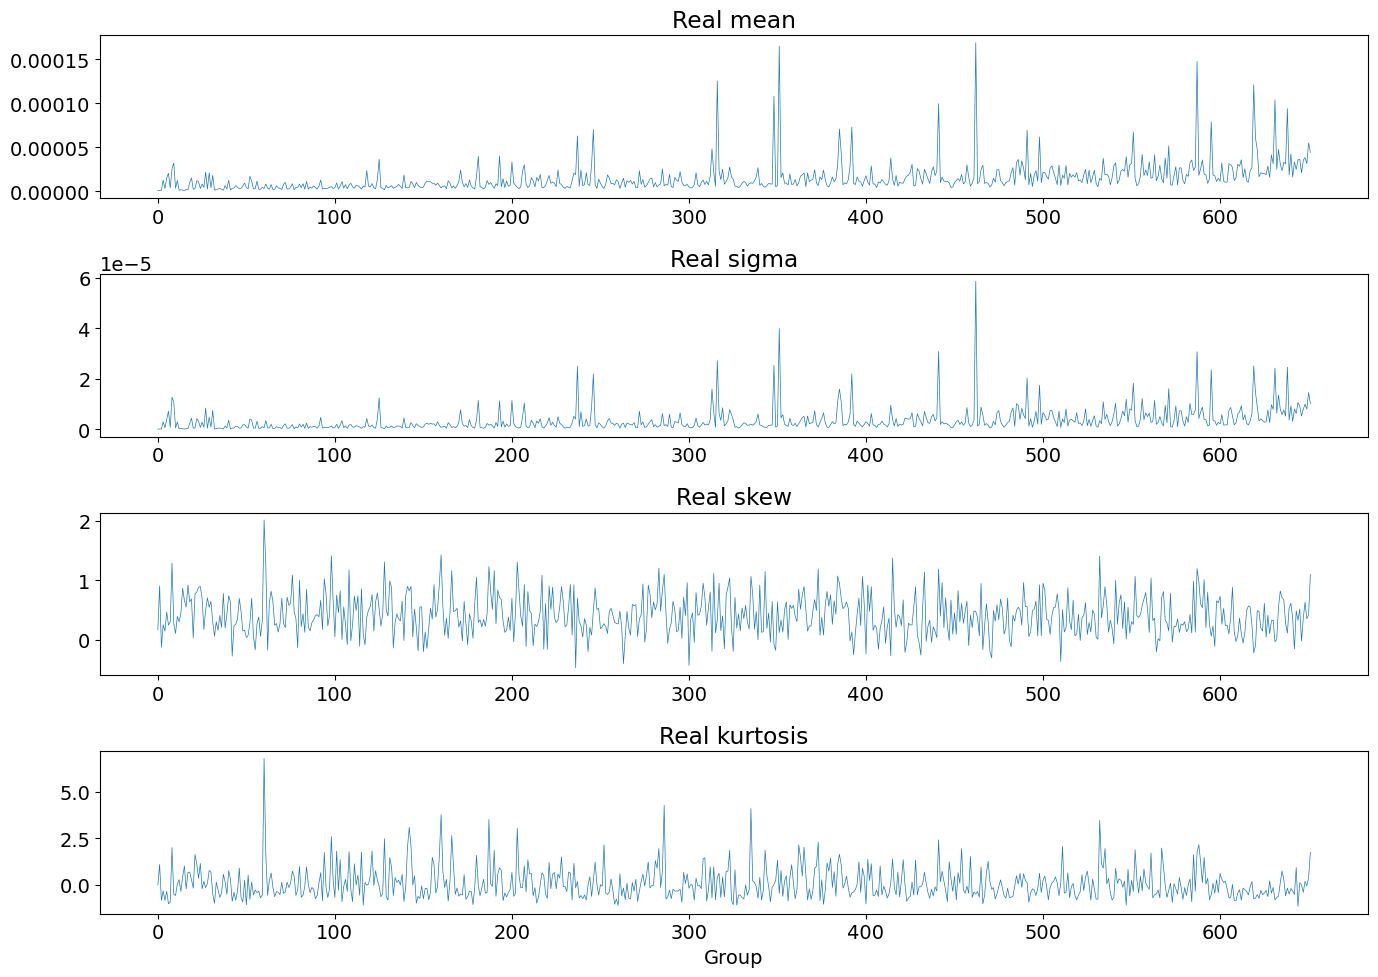

In [76]:
plt.subplot(4, 1, 1)    
real_means = [ np.mean(group.real) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_means, label="Real means", lw=0.5)
plt.title("Real mean")
plt.subplot(4, 1, 2)    
real_std = [ np.std(group.real) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_std, label="Real sigma", lw=0.5)
plt.title("Real sigma")
plt.subplot(4, 1, 3)    
real_skew = [ scipy.stats.skew(group.real) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_skew, label="Real skew", lw=0.5)
plt.title("Real skew")
plt.subplot(4, 1, 4)    
real_kurt = [ scipy.stats.kurtosis(group.real) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_kurt, label="Real kutosis", lw=0.5)
plt.title("Real kurtosis")
plt.xlabel("Group")
plt.tight_layout()

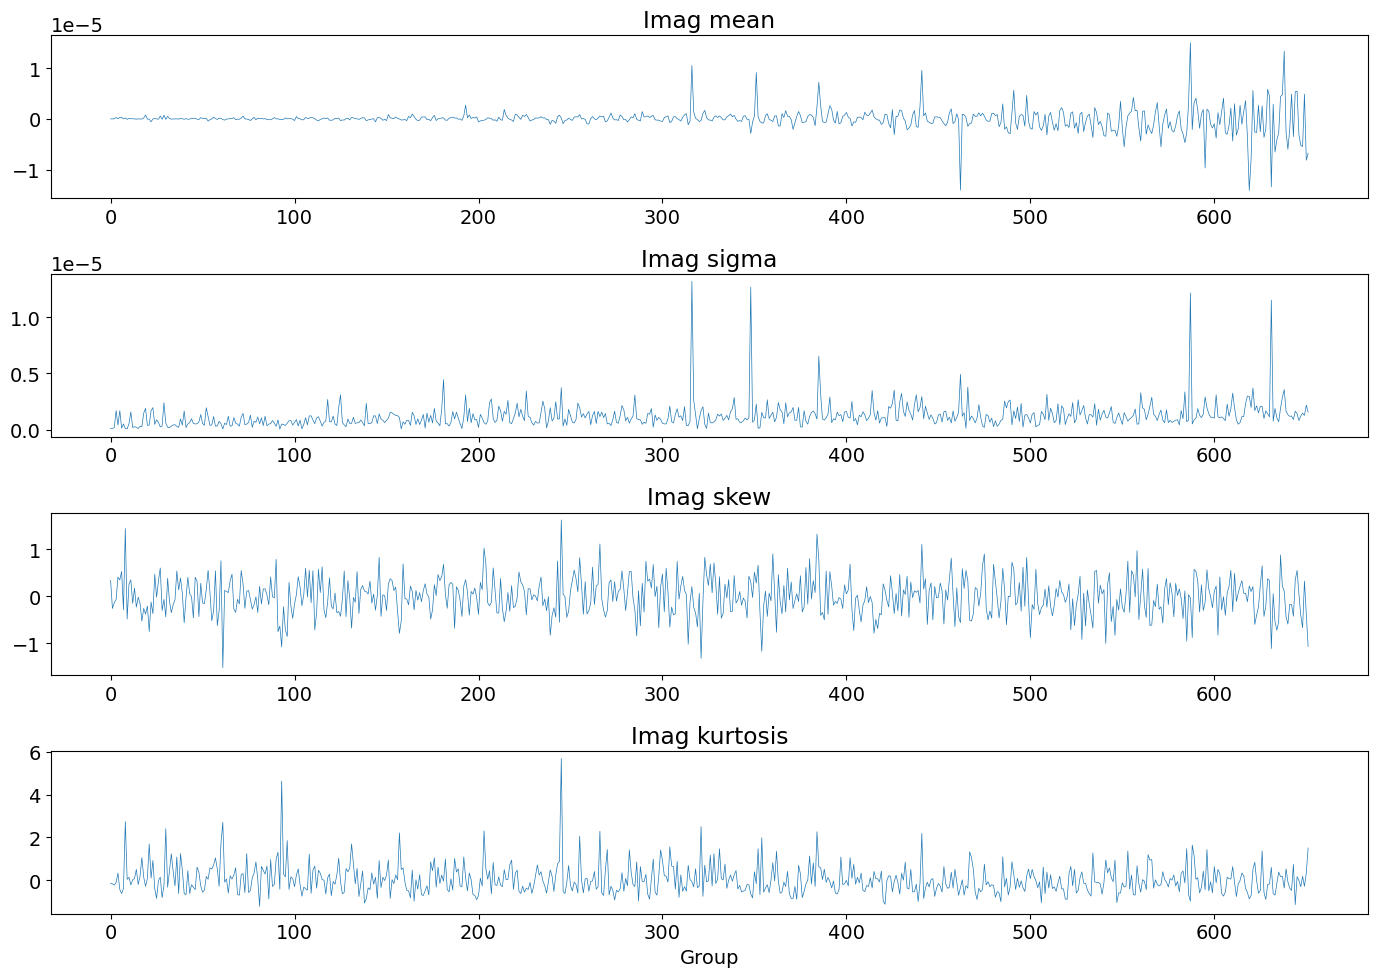

In [77]:
plt.subplot(4, 1, 1)    
real_means = [ np.mean(group.imag) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_means, label="Imag means", lw=0.5)
plt.title("Imag mean")
plt.subplot(4, 1, 2)    
real_std = [ np.std(group.imag) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_std, label="Imag sigma", lw=0.5)
plt.title("Imag sigma")
plt.subplot(4, 1, 3)    
real_skew = [ scipy.stats.skew(group.imag) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_skew, label="Imag skew", lw=0.5)
plt.title("Imag skew")
plt.subplot(4, 1, 4)    
real_kurt = [ scipy.stats.kurtosis(group.imag) for i, group in enumerate(integrated) if i not in empties ]
plt.plot(real_kurt, label="Imag kutosis", lw=0.5)
plt.title("Imag kurtosis")
plt.xlabel("Group")
plt.tight_layout()

Before folding, Range: 4.1593140898014165e-07 - 0.0003141794848324733
After dimensionless, Range: 4.43770196461998e-16 - 3.7117294253984626e-05


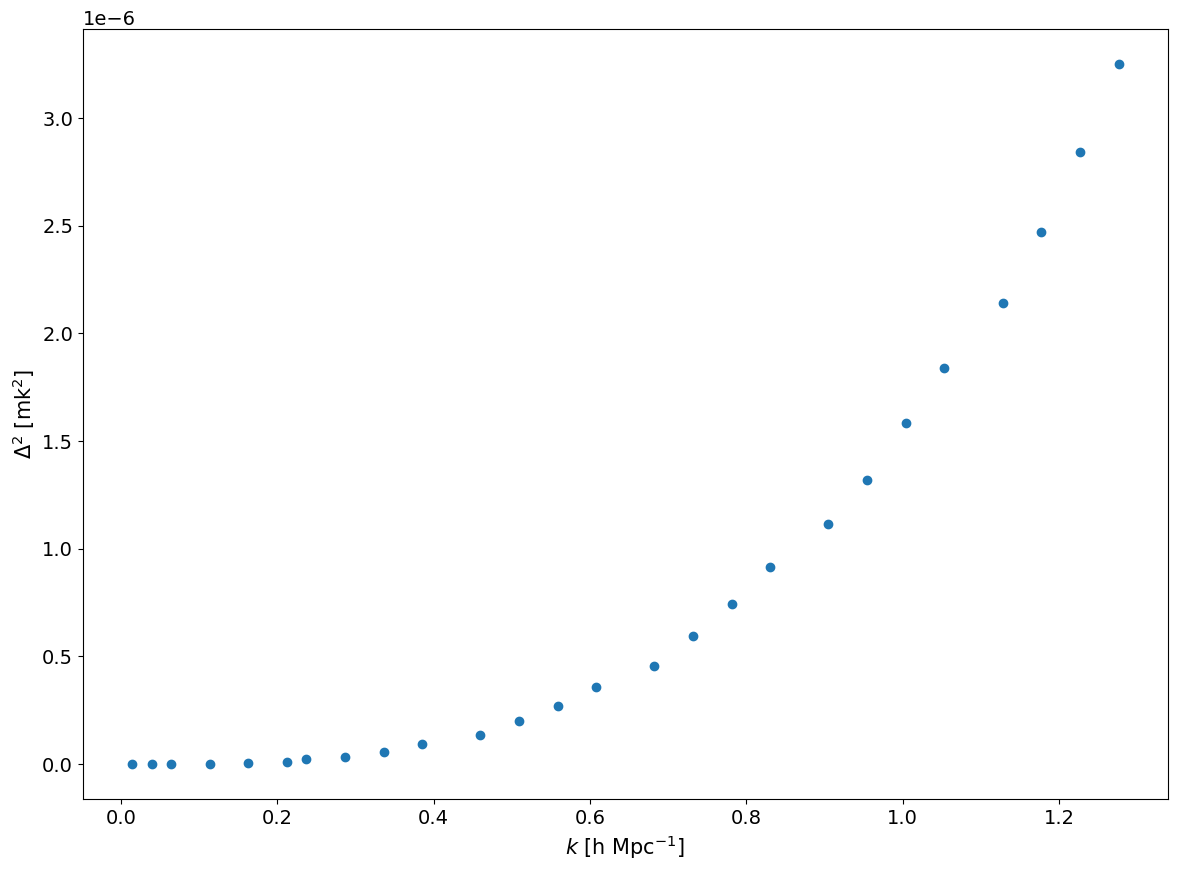

In [78]:
spherical_average(integrated, 52)

Before binning, Range: 4.1593140898014165e-07 - 0.0003141794848324733
After binning, Range: 8.738434008523795e-07 - 6.0786570969752907e-05


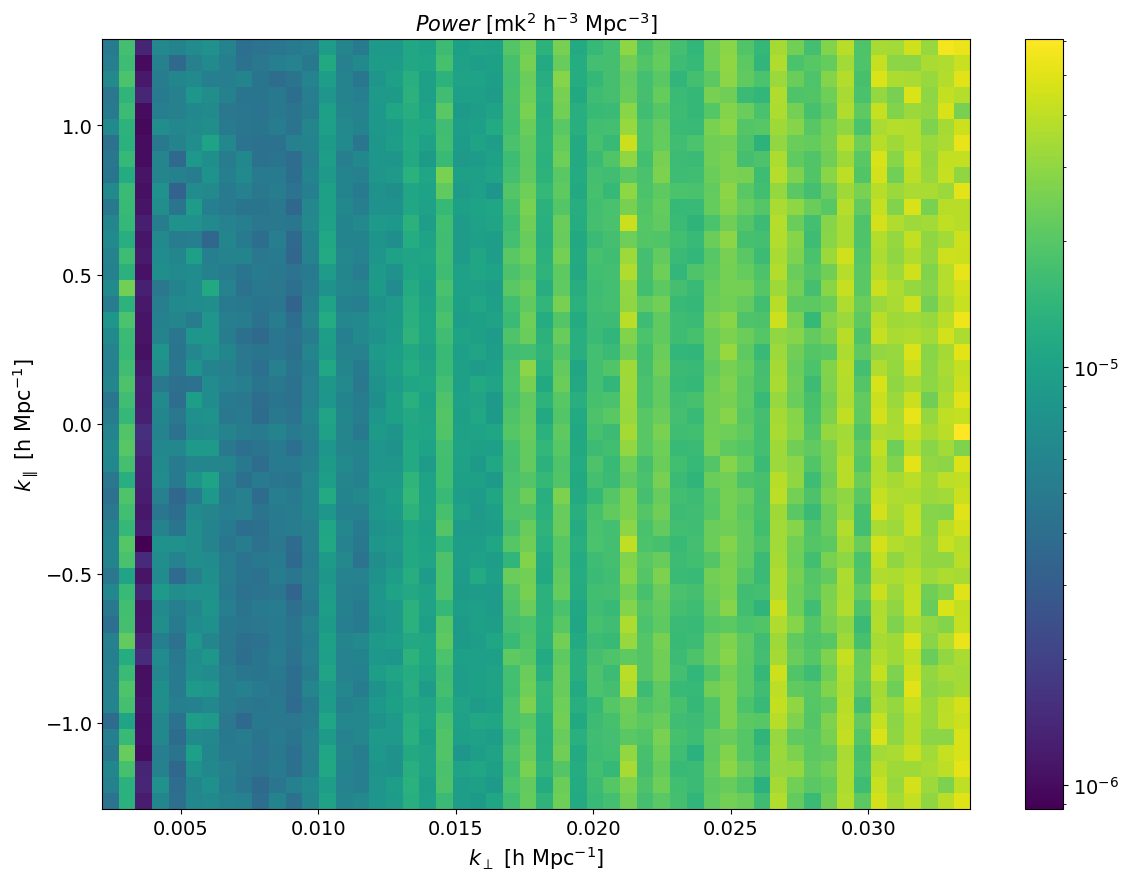

In [79]:
make_wedge(integrated, 52)

Real. Mean: 0.0 Std 1.288620010900883e-07 Skew 0.16 Kurtosis -0.02
Imag. Mean: 0.0 Std 1.0252768245267671e-07 Skew 0.34 Kurtosis -0.15
Amp. Mean: 0.0 Std 1.2916518962183447e-07 Skew 0.12 Kurtosis -0.15


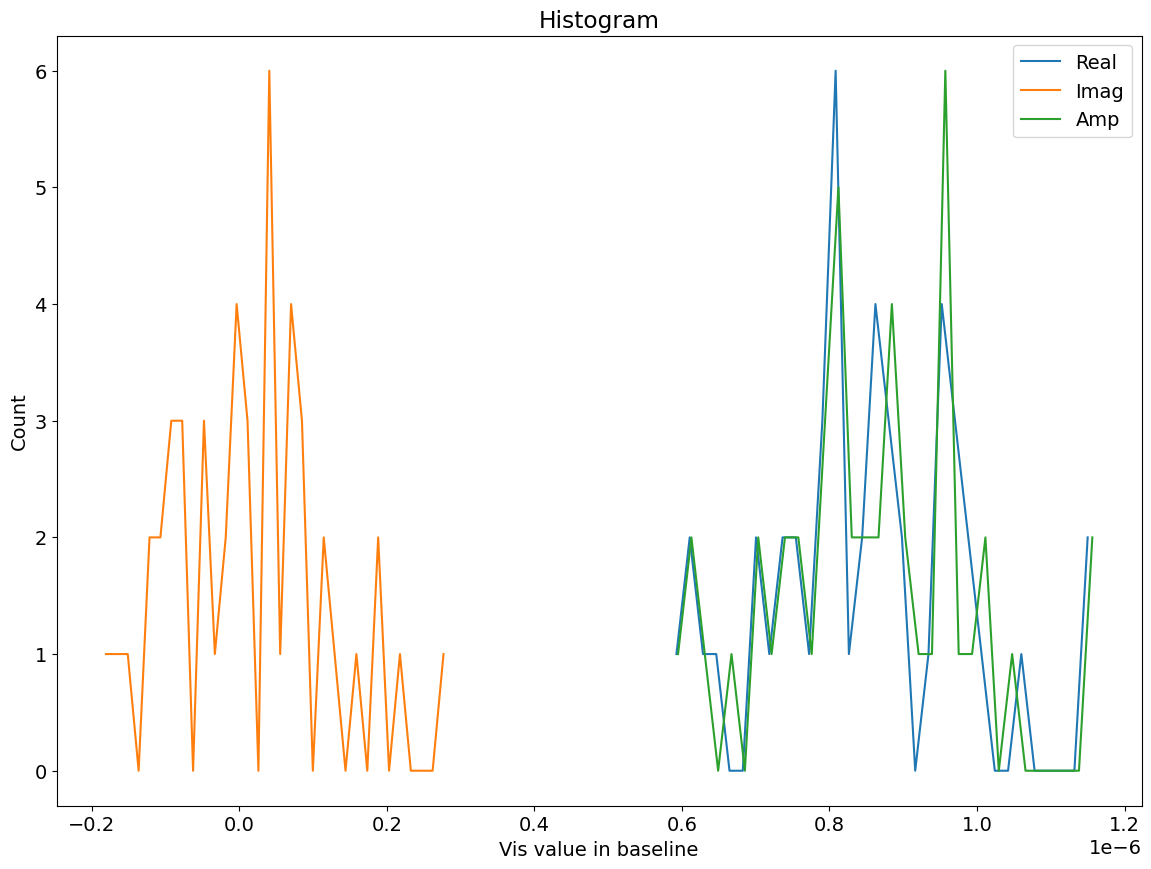

In [80]:
plot_histogram(integrated[0], "Vis value in baseline", nbins=32)

# Appendix A

How to get power, and when there are positive and negative frequencies. Create a signal, get the power from the signal and the FFT and check they match.

In [81]:
length = 1024

# Positive and negative frequencies ------------------------

fft = np.zeros(length, dtype=complex)
fft[length//2-16] = 1.4*np.exp(-1j*np.pi/7)*length
fft[length//2+16] = 2.876*np.exp(-1j*np.pi*1.3)*length

print("When a mode has both positive and gentive freqiencies ----")

data = np.fft.ifft(np.fft.ifftshift(fft))
print("Power from signal in time domain", np.mean(np.abs(data)**2))

fft = np.fft.fftshift(np.fft.fft(data))/length       # Divide by length is to normalize
print("Power from signal in the FFT domain", np.abs(fft[length//2-16])**2+np.abs(fft[length//2+16])**2)  # Add +/-ve

# DC mode ----------------------------------------------
fft = np.zeros(length, dtype=complex)
fft[length//2] = 3*np.exp(-1j*np.pi/3)*length


print("DC mode ----")

data = np.fft.ifft(np.fft.ifftshift(fft))
print("Power from signal in time domain", np.mean(np.abs(data)**2))

fft = np.fft.fftshift(np.fft.fft(data))/length     
print("Power from signal in the FFT domain", np.abs(fft[length//2])**2)


# Nyquist mode ----------------------------------------------
fft = np.zeros(length, dtype=complex)
fft[0] = 1.2*np.exp(-1j*np.pi/.8)*length

print("Nyquist mode ----")

data = np.fft.ifft(np.fft.ifftshift(fft))
print("Power from signal in time domain", np.mean(np.abs(data)**2))

fft = np.fft.fftshift(np.fft.fft(data))/length
print("Power from signal in the FFT domain", np.abs(fft[0])**2)


When a mode has both positive and gentive freqiencies ----
Power from signal in time domain 10.231376000000001
Power from signal in the FFT domain 10.231376
DC mode ----
Power from signal in time domain 9.000000000000002
Power from signal in the FFT domain 9.000000000000004
Nyquist mode ----
Power from signal in time domain 1.4400000000000002
Power from signal in the FFT domain 1.44


### Conclusion

Given a two-sided FFT (+ve and -ve frequenices)
1. Square all the values (or in case of cross-power this is the same as making the crosspowers). If the values are complex, do abs(val)**2
2. For the modes with positive and negative frequencies, add the squared value in the positive and negative sides of the mode. 



# Appendix B

Does a crosspower retain Gaussianity?

Real. Mean: 0.0 Std 1.0011531324086738 Skew 0.0 Kurtosis -0.01
Imag. Mean: -0.0 Std 1.0000634271291315 Skew 0.0 Kurtosis -0.01
Amp. Mean: 1.25 Std 0.6551742188771479 Skew 0.63 Kurtosis -0.01


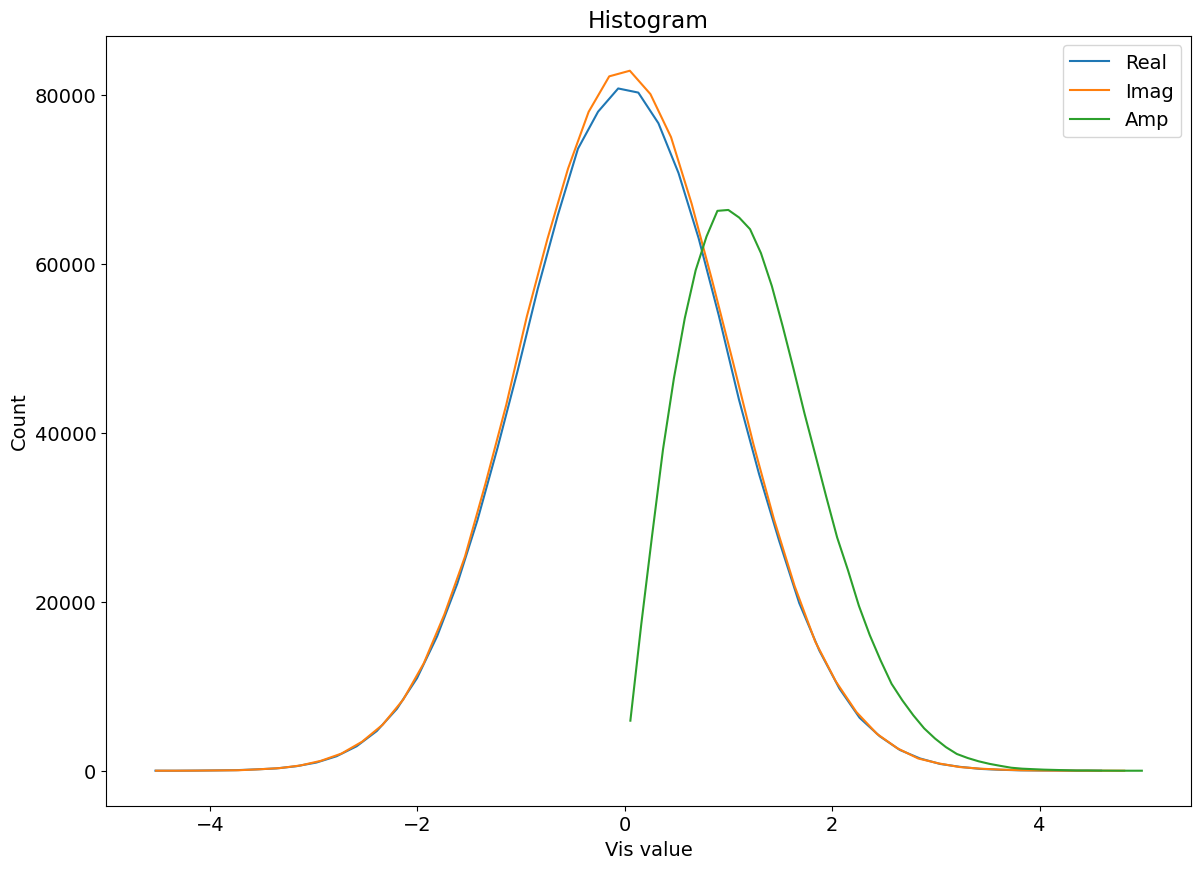

In [82]:
length = 1024*1024
bl1 = np.random.normal(size=length)+np.random.normal(size=length)*1j
bl2 = np.random.normal(size=length)+np.random.normal(size=length)*1j
plot_histogram(bl1, "Vis value", nbins=48)

Real. Mean: 0.0 Std 1.4174844887895288 Skew -0.01 Kurtosis 3.0
Imag. Mean: 0.0 Std 1.4151886547115633 Skew -0.0 Kurtosis 3.01
Amp. Mean: 1.57 Std 1.240400006802438 Skew 1.6 Kurtosis 3.01


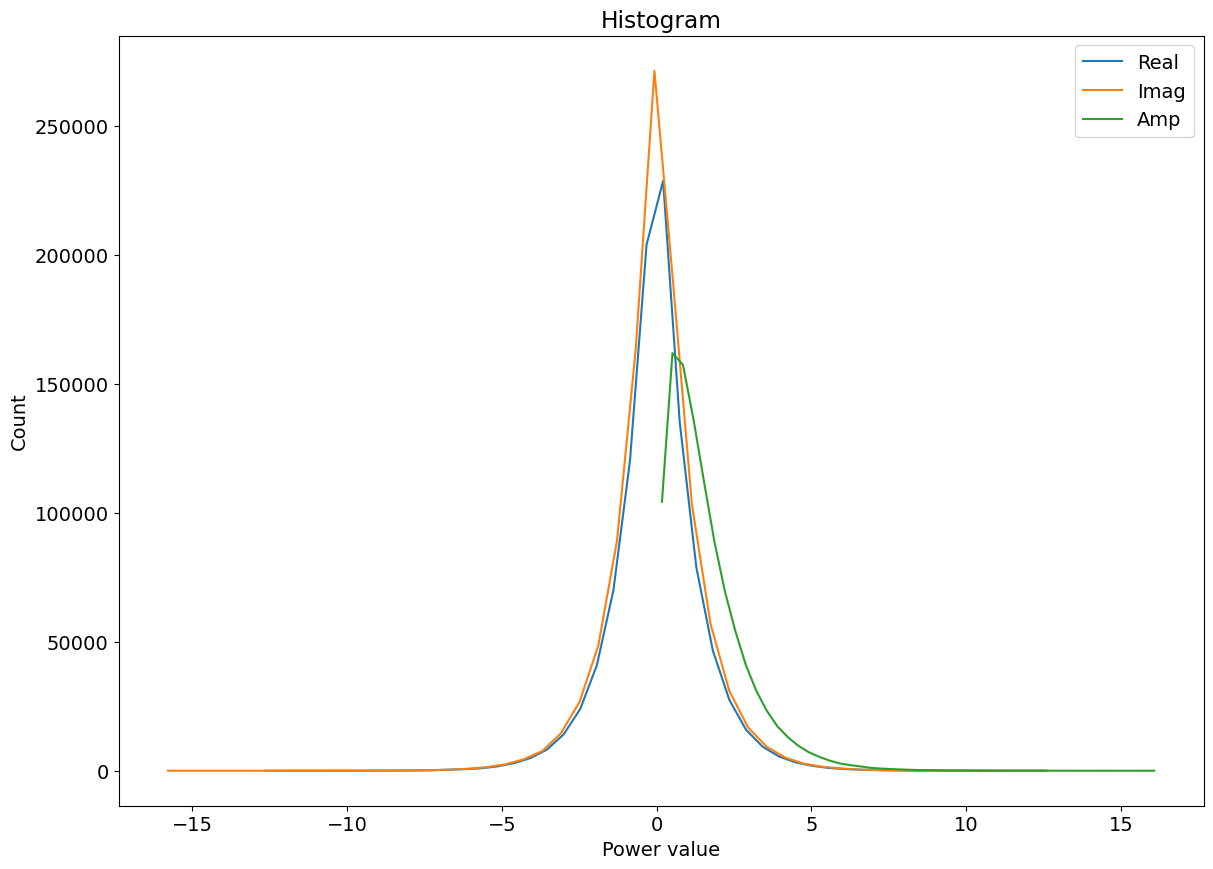

In [83]:
cross_power = bl1*np.conj(bl2)
plot_histogram(cross_power, "Power value", nbins=48)

### Conclusion

No Gaussianity is not preserved.